In [1]:
import datajoint as dj
import os

os.chdir('../..')
dj.config.load('dj_local_conf.json')

import pathlib
import numpy as np
import pandas as pd
import datetime
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
mlims = dj.create_virtual_module('mlims', dj.config['custom'].get('mlims.database'))
from ephys import (reference, ephys, acquisition, behavior, tracking, analysis, analysis_param)

Connecting thinh@datajoint.it.ntnu.no:3306


# Recap from Part 1

From the Part 1 [notebook](Part_1_spikes_and_tracking.ipynb), we've demonstrated how ones can navigate through the ***analysis*** schema portion of the pipeline to explore and retreive spikes, tracking, cell-analysis results. 

The major obstacles there are the numerous combinations of choices that users have to decide on, and more importantly to construct queries correctly, to get to a certain "final stage" results - e.g. grid score, speed score, ratemap, etc. 

The choices include:
+ Session and task (the easy ones)
+ Cluster Group and Cluster Windows 
+ Clustering Curation
+ Analysis parameters 
    + CellSelectionParams
    + FieldDetectParams
    + OccupancyParams
    + SmoothingParams
    + ScoreParams
    + ShuffleParams
+ Analysis package - python vs. MATLAB

The most involved choices are the 'Cluster Group and Cluster Windows' and 'Curations', illustrated here:

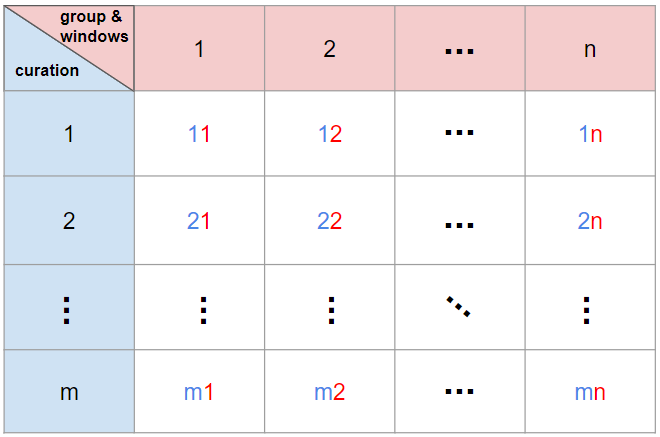

In [3]:
from IPython.display import Image
Image(filename='images/Clustering_ChoiceMatrix.png', width=400, height=300) 

Often time, this seems overwhelming for those with just a simple question:
>I just want to look at the ratemap for unit #4 from the session I just inserted, during the "OpenField" task

That probably translates to: 
+ The ***ClusterSessionGroup*** contains that one session
+ The ***ClusterTimeWindows*** contains 1 time-window, with time spans the entire session
+ There is only one curation, that's the one I want to look at
+ Results are analyzed using my usual set of analysis parameters, I'd much rather not re-picking them every single time
+ I want to look at MATLAB results, always MATLAB results

To this end, there are several "configuration" tables embedded into the pipeline to allow for any particular user to set up his/her "usual" settings for visualizing end results.

# The `FinalizedClustering` table

For any given ***clustering*** routine, there can be multiple subsequent ***curations*** on those clustering results. Yet there should only be one ***curation*** that is best, and is to be further inspected, analyzed, interpreted for potential publication. We refer to that one as the ***FinalizedClustering***

In [4]:
ephys.FinalizedClustering.describe();

-> acquisition.ClusterTimeWindows
-> acquisition.ProbeInsertion
---
-> ephys.CuratedClustering



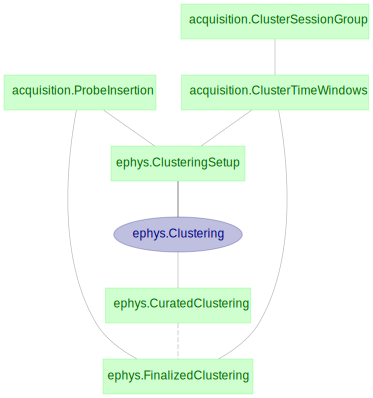

In [5]:
(dj.ERD(ephys.FinalizedClustering) - 1) + dj.ERD(acquisition.ClusterSessionGroup) + dj.ERD(ephys.ClusteringSetup)

By definition, from all performed ***curations*** there can only be one ***Finalized Curated Clustering*** result for each ***ClusteringTimeWindows*** and ***ProbeInsertion*** combination (since one ***Clustering*** is performed on this)

User can designate any one ***CuratedClustering*** as the ***FinalizedClustering***

In [6]:
all_curations = ephys.CuratedClustering.fetch('KEY')

In [7]:
ephys.FinalizedClustering.insert1(all_curations[0], skip_duplicates=True)

Once ***FinalizedClustering*** is specified, we at least narrow the choices on the row of the choice-matrix.

We can also narrow the choices on the column, by just selecting the ***default*** group and time-window (a short-cut is to use the built-in function `get_default_cluster_time_window()` described in Part 1)

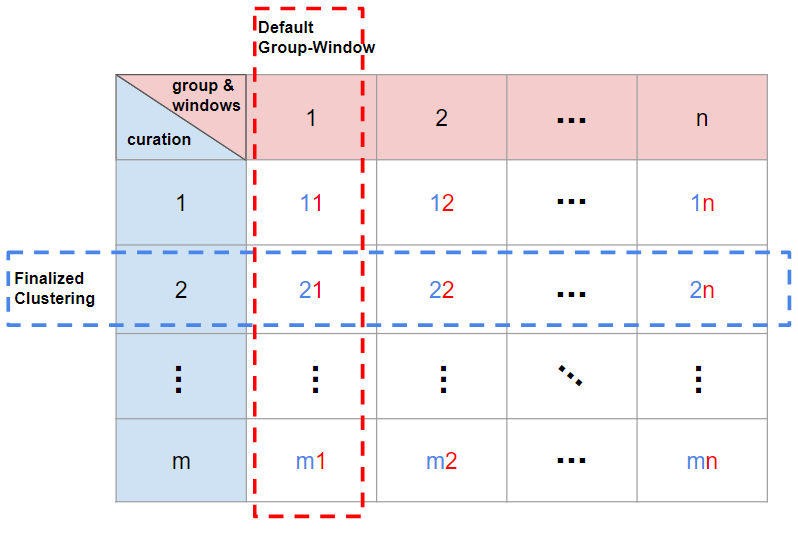

In [8]:
from IPython.display import Image
Image(filename='images/Clustering_ChoiceMatrix_FinalizedSelector.png', width=400, height=300) 

# The `FavoriteSelection` table

In [11]:
analysis_param.FavoriteSelection.describe();

-> reference.Experimenter.proj(user="experimenter")
---
-> analysis_param.CellAnalysisMethod
-> analysis_param.AnalysisPackage



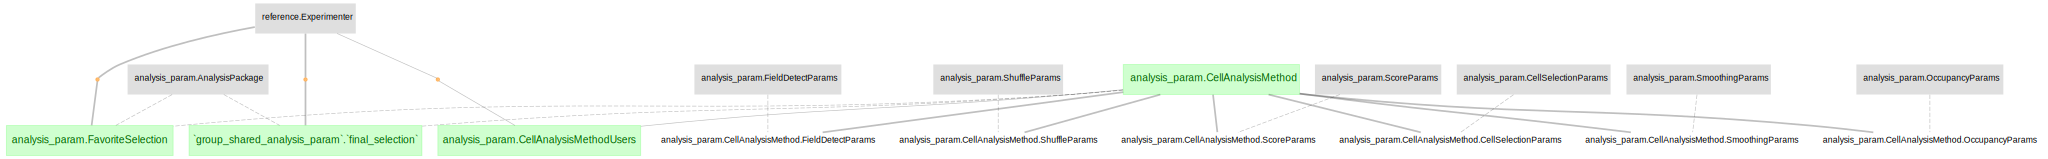

In [12]:
dj.ERD(analysis_param) + dj.ERD(reference.Experimenter)

Every ***user*** can configure a "favorite" setting for querying analysis results in the `FavoriteSelection` table, the attributes to configure are:
+ CellAnalysisMethod - which include all the choices for analysis parameter-set
+ AnalysisPackage - MATLAB or Python

The `FavoriteSelection` has a built-in `get_restrictor()` method:
>restrictor = FinalSelection().get_restrictor(user, session_key)

Given a ***session_key***, this method will return a list of dict restriction that would restrict any analysis query to the favorite setting of the specified ***user***. In particular, the restrictions are:
+ To the ***default*** cluster group and time-window for this ***session_key***
+ To the ***FinalizedClustering*** for the ***default*** group and time-window
    + Note: if no ***FinalizedClustering*** defined, then the most recent ***CuratedClustering*** will be selected
+ To all cell analysis parameter-set chosen as favorite for this ***user***
+ To the analysis package (MATLAB or Python) preselected for this ***user***

Once setup, users can quickly get to the answer of the above question:
> I just want to look at the ratemap for unit #4 from the session I just inserted, during the "OpenField" task

With: 
> ratemap = (analysis.RateMap * analysis.TaskSpikesTrackingProxy & analysis_param.FinalSelection().get_restrictor(user, session_key)
& session_key & 'task = "OpenField" & 'unit = 4').fetch1('ratemap)

### Specify your "favorite" setting, insert into `FavoriteSelection`

In [ ]:
analysis_param.FavoriteSelection.insert1({'user': 'davidcr', 'cell_analysis_method': 'method_1', 'analysis_package': 'python'})

In [ ]:
behavior.Task()

In [ ]:
session_key = {'animal_id': '00117ffddc698482', 'session_time': '2019-03-27 10:36:57'}

In [ ]:
restrictor = analysis_param.FavoriteSelection().get_restrictor('davidcr', session_key)

In [ ]:
restrictor

### To demonstrate, let's build the query slowly

In [29]:
analysis.RateMap & restrictor

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamps of task onset with respect to the start of the session,unit unit id,spike_tracking_hash hash of the SpikesTracking primary_key,cell_selection_params_name user-friendly name,tracking_time start time of this tracking recording,tracking_processing_method,sync_method sync method name,"occu_params_name Parameter set ID, starting with 'default'",smoothing_params_name,analysis_package,"field_detect_params_name Field detection method name, starting with A",ratemap Smoothed 2D ratemap # 1 map.z,ratemap_mask Mask (where time = 0) # 1 isnan(map.zRaw),ratemap_raw Unsmoothed ratemap # 1 map.zRaw,fieldmap 2 fieldsMap,field_quantity 2 size(fields),peak_rate,mean_rate 4,spatial_information_rate 3 information.rate,spatial_information_content 3 information.content,spatial_coherence 5 coherence,selectivity 3 selectivity,sparsity 5 sparsity
00117ffddc698482,0,2019-03-27 10:36:57,OpenField,0.00,6004,39a9159bc804785a62a8de37858cd202,1,2019-03-27 10:36:57,2d_2led,presync,1,1,python,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,6,24.4016,3.59713,2.54367,0.769788,0.00438406,7.38463,0.494751
00117ffddc698482,0,2019-03-27 10:36:57,PhotoStim,1604.00,6009,3fc62ad1afda5bd6fe3ed22379fc2373,1,2019-03-27 11:03:41,2d_2led,presync,1,1,python,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2,11.4498,2.02177,0.505462,0.362999,0.174637,8.22269,0.755516


In [30]:
analysis.RateMap & restrictor & session_key & 'task_type = "OpenField"'

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamps of task onset with respect to the start of the session,unit unit id,spike_tracking_hash hash of the SpikesTracking primary_key,cell_selection_params_name user-friendly name,tracking_time start time of this tracking recording,tracking_processing_method,sync_method sync method name,"occu_params_name Parameter set ID, starting with 'default'",smoothing_params_name,analysis_package,"field_detect_params_name Field detection method name, starting with A",ratemap Smoothed 2D ratemap # 1 map.z,ratemap_mask Mask (where time = 0) # 1 isnan(map.zRaw),ratemap_raw Unsmoothed ratemap # 1 map.zRaw,fieldmap 2 fieldsMap,field_quantity 2 size(fields),peak_rate,mean_rate 4,spatial_information_rate 3 information.rate,spatial_information_content 3 information.content,spatial_coherence 5 coherence,selectivity 3 selectivity,sparsity 5 sparsity
00117ffddc698482,0,2019-03-27 10:36:57,OpenField,0.00,6004,39a9159bc804785a62a8de37858cd202,1,2019-03-27 10:36:57,2d_2led,presync,1,1,python,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,6,24.4016,3.59713,2.54367,0.769788,0.00438406,7.38463,0.494751


In [31]:
analysis.RateMap * analysis.TaskSpikesTrackingProxy & restrictor & session_key & 'task_type = "OpenField"' & 'unit = 6004'

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamps of task onset with respect to the start of the session,unit unit id,spike_tracking_hash hash of the SpikesTracking primary_key,cell_selection_params_name user-friendly name,tracking_time start time of this tracking recording,tracking_processing_method,sync_method sync method name,"occu_params_name Parameter set ID, starting with 'default'",smoothing_params_name,analysis_package,"field_detect_params_name Field detection method name, starting with A",ratemap Smoothed 2D ratemap # 1 map.z,ratemap_mask Mask (where time = 0) # 1 isnan(map.zRaw),ratemap_raw Unsmoothed ratemap # 1 map.zRaw,fieldmap 2 fieldsMap,field_quantity 2 size(fields),peak_rate,mean_rate 4,spatial_information_rate 3 information.rate,spatial_information_content 3 information.content,spatial_coherence 5 coherence,selectivity 3 selectivity,sparsity 5 sparsity
00117ffddc698482,0,2019-03-27 10:36:57,OpenField,0.00,6004,39a9159bc804785a62a8de37858cd202,1,2019-03-27 10:36:57,2d_2led,presync,1,1,python,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,6,24.4016,3.59713,2.54367,0.769788,0.00438406,7.38463,0.494751


In [32]:
ratemap = (analysis.RateMap * analysis.TaskSpikesTrackingProxy & restrictor & session_key & 'task_type = "OpenField"' & 'unit = 6004').fetch1('ratemap')

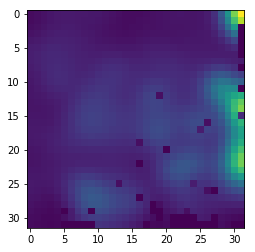

In [33]:
plt.imshow(ratemap)